# SHAP Values

Veremos brevemente un modelo de interpretabilidad para modelos complejos de machine learning como es un LGBM.

El uso de **python** para esta exploración se debe a la madurez encontrada en las librerías en mi búsqueda.

Empezamos con la carga de los módulos necesarios:

In [2]:
import pandas as pd
import numpy as np

import lightgbm as lgb

Cargamos con **pandas** lentamente el dataset. Sólo vamos a trabajar con el primer conjunto de datos que es el más pequeño. Con un poco más de paciencia podrá usar los conjuntos más pesados. 

In [3]:
df_train = pd.read_csv("../../../datasets/competencia1_2022.csv")

Xtrain = df_train[df_train["foto_mes"] == 202101]
ytrain = Xtrain["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)

C:\Users\programadorweb4\AppData\Local\Temp\ipykernel_32020\643494372.py:1: DtypeWarning: Columns (154) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("../../../datasets/competencia1_2022.csv")


Separamos también todos los casos de **BAJAS+1** y **BAJAS+2**

In [4]:
Xbajas = df_train.query("foto_mes == 202101 and clase_ternaria != 'CONTINUA'")

In [5]:
print(Xtrain.shape)
print(ytrain.shape)
print(Xbajas.shape)

(161342, 155)
(161342,)
(1514, 155)


Y nos deshacemos del target y limpiamos un poco la memoria.

In [6]:
Xtrain = Xtrain.drop("clase_ternaria", axis=1)
Xbajas = Xbajas.drop("clase_ternaria", axis=1)

del(df_train)

Hacemos un modelo **LGBM**

In [7]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(Xtrain, ytrain)

# specify your configurations as a dict
params = {
    'objective': 'binary',
    'learning_rate': 0.05,
    'verbose': 2,
    'max_bin': 15,
    'min_data_in_leaf': 4000,
    'verbose': 0,
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Y miramos su importancia de variables

In [8]:
lgbm_importancia = pd.DataFrame({'Features': gbm.feature_name(),
                        'Importances': gbm.feature_importance()})
lgbm_importancia.sort_values(by='Importances', inplace=True, ascending=False)
lgbm_importancia


,Features,Importances
5,cliente_edad,141
107,ctrx_quarter,126
8,mrentabilidad_annual,119
10,mactivos_margen,103
22,mcuentas_saldo,91
...,...,...
76,cforex_buy,0
75,cforex,0
70,mtarjeta_master_descuentos,0
69,ctarjeta_master_descuentos,0


Ahora avanzamos aplicando un modelo de interpretabilidad sobre el modelo anterior.

In [9]:
import shap

In [10]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(Xbajas)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Consolidamos los valores de **SHAP** para cada variable y para cada **BAJA+\***

In [11]:
shap_bajas = pd.DataFrame(shap_values[0], columns = Xbajas.columns)
shap_bajas

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,Visa_madelantodolares,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo
0,-0.004904,0.0,0.0,0.0,-0.002334,0.043758,0.013983,-0.041278,0.196130,0.000189,...,0.0,-0.000616,0.011454,-0.014267,-0.002817,-0.021265,0.0,-0.015299,0.0,-0.053038
1,-0.013970,0.0,0.0,0.0,-0.004382,0.048569,0.011794,0.006623,-0.096754,-0.011399,...,0.0,0.001421,-0.057956,-0.006672,0.011768,0.004617,0.0,-0.003721,0.0,-0.060725
2,-0.022926,0.0,0.0,0.0,-0.001292,-0.410950,0.011234,0.023368,0.058636,0.006585,...,0.0,0.001724,-0.030290,0.008067,-0.001562,-0.001833,0.0,-0.007120,0.0,0.016079
3,-0.018709,0.0,0.0,0.0,-0.002978,-0.213675,0.009803,-0.010034,-0.031874,-0.016405,...,0.0,0.001045,-0.000576,-0.014958,-0.003360,-0.063228,0.0,-0.000538,0.0,-0.111314
4,-0.012726,0.0,0.0,0.0,-0.002094,-0.203420,0.014232,-0.044485,0.168928,-0.012609,...,0.0,-0.002317,0.011874,-0.029288,-0.002845,-0.056215,0.0,-0.005447,0.0,-0.099260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509,0.022436,0.0,0.0,0.0,-0.001274,0.045961,-0.071549,0.013633,-0.094009,-0.014529,...,0.0,0.001330,0.001324,-0.026429,-0.002340,0.062294,0.0,0.005572,0.0,0.079506
1510,0.014711,0.0,0.0,0.0,-0.002212,0.031978,-0.073241,0.003024,-0.105791,0.000905,...,0.0,0.001267,0.000154,-0.013291,0.011133,0.055093,0.0,0.003651,0.0,-0.071855
1511,0.015259,0.0,0.0,0.0,-0.002597,0.053010,-0.078954,0.022112,-0.120325,-0.005999,...,0.0,0.001442,0.000127,-0.011322,0.013452,0.080696,0.0,-0.000698,0.0,-0.128532
1512,0.005852,0.0,0.0,0.0,-0.003329,-0.179921,-0.070015,-0.004753,-0.104875,-0.015815,...,0.0,0.001135,-0.000063,-0.009317,0.012196,0.086014,0.0,-0.000202,0.0,-0.069681


Y consolidamos sus importancias

In [12]:
shap_importancias = shap_bajas.abs().mean().sort_values(ascending=False)
shap_importancias

ctrx_quarter                       1.019456
cpayroll_trx                       0.664193
mtarjeta_visa_consumo              0.240068
mcuentas_saldo                     0.203344
mprestamos_personales              0.197923
                                     ...   
mcheques_emitidos_rechazados       0.000000
ccheques_emitidos_rechazados       0.000000
mcheques_depositados_rechazados    0.000000
ccheques_depositados_rechazados    0.000000
mforex_buy                         0.000000
Length: 154, dtype: float64

La librería nos da útiles herramientas para vizualizar la info anterior

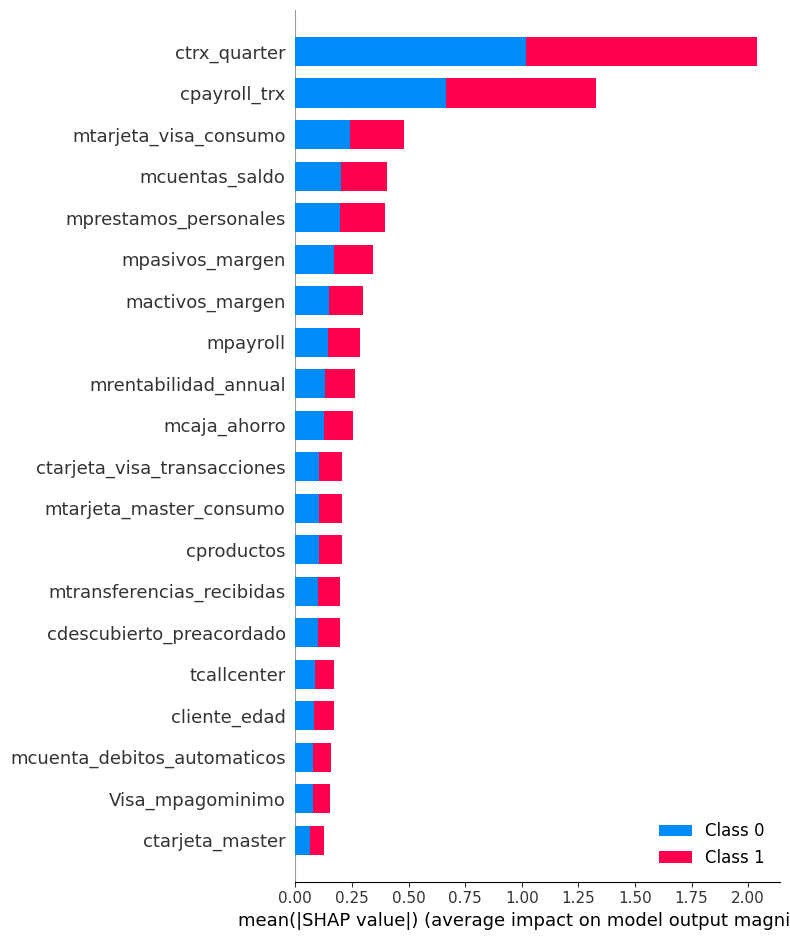

In [13]:
summary_plot = shap.summary_plot(shap_values, Xbajas)

Y ahora debemos empezar a jugar para entender como estan asociadas las variables a los **shap values**

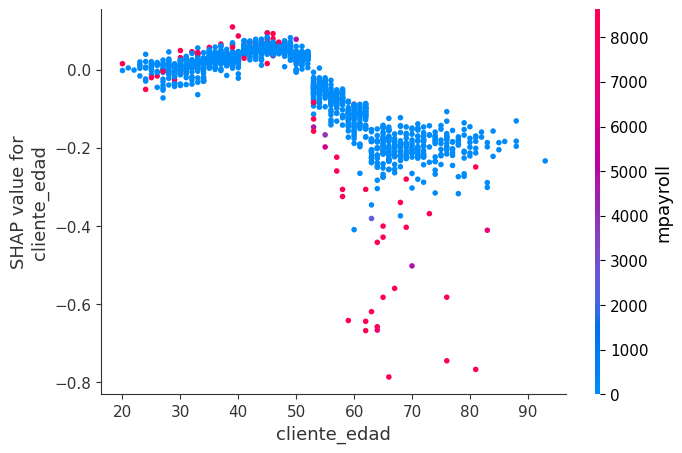

In [14]:
shap.dependence_plot("cliente_edad", shap_values[0], Xbajas)

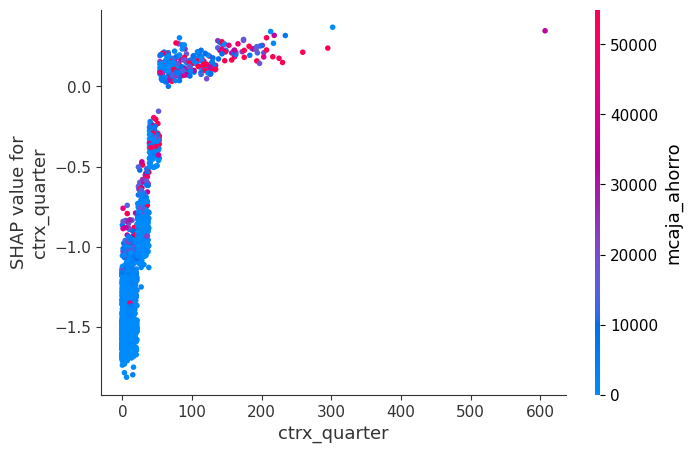

In [15]:
shap.dependence_plot("ctrx_quarter", shap_values[0], Xbajas)

¿Se podrá hacer una clusterización sobre los valores de shap? 

Como la cantidad de variables es muy alto, es conveniente hacer un embedding con **UMAP**. Como la estrutura de los **shap values** se pueden hacer sin mucho preprocesamiento.

In [16]:
from umap import UMAP
import matplotlib.pyplot as plt


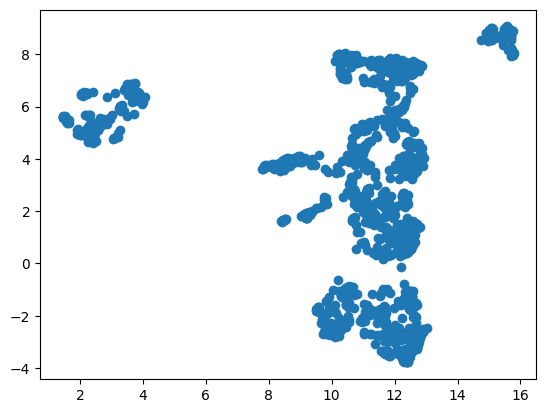

In [17]:
embedding_2d = UMAP(
  n_components=2, n_neighbors=45
).fit_transform(shap_values[0])
plt.scatter(embedding_2d[:,0], embedding_2d[:,1])

In [18]:
embedding_2d.shape

(1514, 2)

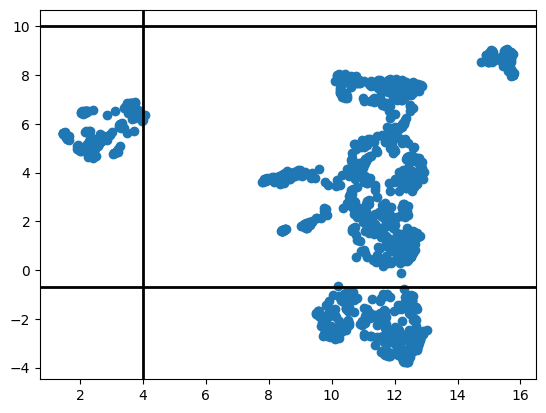

In [19]:
plt.scatter(embedding_2d[:,0], embedding_2d[:,1])
plt.axhline(y=10, linewidth=2, color = 'k')
plt.axvline(x=4, linewidth=2, color = 'k')
plt.axhline(y=-0.7, linewidth=2, color = 'k')

In [20]:
ytrain = Xtrain["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)

KeyError: 'clase_ternaria'

In [ ]:
type(embedding_2d)

numpy.ndarray

In [ ]:
embedding_2d

array([[10.904784 ,  4.8192787],
       [ 1.0906656,  7.6051617],
       [11.2422495, 11.041633 ],
       ...,
       [11.38715  ,  1.864797 ],
       [10.91309  , -2.45098  ],
       [10.2217865, 10.91557  ]], dtype=float32)

In [ ]:
df_embedding = pd.DataFrame(embedding_2d, columns=['x', 'y'], index = Xbajas.index)

In [ ]:
def set_cluster(row):
    if row['x'] > 4 and row['y'] > 10:
        return 1
    if row['x'] < 4 and row['y'] < 10:
        return 2
    if row['x'] > 4 and row['y'] < 10:
        return 3
    return 4

In [ ]:
df_embedding["cluster"] = df_embedding.apply(lambda row: set_cluster(row), axis = 1)

In [ ]:
df_embedding

,x,y,cluster
26,10.904784,4.819279,3
252,1.090666,7.605162,2
322,11.242249,11.041633,1
443,9.664559,1.110566,3
509,8.719440,-2.680423,3
...,...,...,...
160869,9.557488,-1.741820,3
160905,8.186071,3.256927,3
160932,11.387150,1.864797,3
160945,10.913090,-2.450980,3


In [ ]:
Xbajas = Xbajas.drop("cluster", axis=1)

In [ ]:
Xbajas

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,Visa_madelantodolares,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo
26,31127916,202101,1,0,0,42,277,2649.44,30930.84,2519.56,...,0.0,11.0,3485.96,-3448.72,0.0,5103.0,3002.88,2.0,0.0,598.23
252,31282207,202101,0,0,0,44,292,-2313.80,-3919.05,1225.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
322,31328871,202101,1,0,0,83,293,335.32,17274.70,1699.39,...,0.0,25.0,48368.31,-44473.12,0.0,7490.0,2768.26,4.0,0.0,3964.74
443,31406150,202101,1,0,0,69,296,567.94,14262.98,1246.04,...,0.0,4.0,0.00,-13090.55,0.0,4772.0,0.00,0.0,0.0,0.00
509,31449517,202101,1,0,0,71,262,1248.52,17804.40,1823.18,...,0.0,11.0,1777.09,-2250.51,0.0,5673.0,1759.50,1.0,0.0,82.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160869,206768061,202101,1,0,0,44,6,-303.88,2131.57,219.11,...,0.0,4.0,0.00,-1700.86,0.0,174.0,1053.97,1.0,0.0,7999.86
160905,206957932,202101,0,0,0,50,5,0.00,0.00,0.00,...,NaN,4.0,0.00,NaN,NaN,140.0,NaN,NaN,NaN,0.00
160932,207072528,202101,1,0,0,49,2,-79.20,284.25,-85.32,...,NaN,4.0,0.00,NaN,NaN,59.0,NaN,NaN,NaN,0.00
160945,207113408,202101,0,0,0,66,5,4018.70,6948.19,3905.97,...,NaN,4.0,0.00,NaN,NaN,133.0,NaN,NaN,NaN,0.00


In [ ]:
Xbajas = Xbajas.join(df_embedding["cluster"])

In [ ]:
Xbajas

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo,cluster
26,31127916,202101,1,0,0,42,277,2649.44,30930.84,2519.56,...,11.0,3485.96,-3448.72,0.0,5103.0,3002.88,2.0,0.0,598.23,3
252,31282207,202101,0,0,0,44,292,-2313.80,-3919.05,1225.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
322,31328871,202101,1,0,0,83,293,335.32,17274.70,1699.39,...,25.0,48368.31,-44473.12,0.0,7490.0,2768.26,4.0,0.0,3964.74,1
443,31406150,202101,1,0,0,69,296,567.94,14262.98,1246.04,...,4.0,0.00,-13090.55,0.0,4772.0,0.00,0.0,0.0,0.00,3
509,31449517,202101,1,0,0,71,262,1248.52,17804.40,1823.18,...,11.0,1777.09,-2250.51,0.0,5673.0,1759.50,1.0,0.0,82.11,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160869,206768061,202101,1,0,0,44,6,-303.88,2131.57,219.11,...,4.0,0.00,-1700.86,0.0,174.0,1053.97,1.0,0.0,7999.86,3
160905,206957932,202101,0,0,0,50,5,0.00,0.00,0.00,...,4.0,0.00,NaN,NaN,140.0,NaN,NaN,NaN,0.00,3
160932,207072528,202101,1,0,0,49,2,-79.20,284.25,-85.32,...,4.0,0.00,NaN,NaN,59.0,NaN,NaN,NaN,0.00,3
160945,207113408,202101,0,0,0,66,5,4018.70,6948.19,3905.97,...,4.0,0.00,NaN,NaN,133.0,NaN,NaN,NaN,0.00,3


Su momento de brillar: Qué se puede hacer desde este punto para tratar de interpretar los distintos segmentos para la presentación de Miranda.

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn_extra.cluster import KMedoids

In [ ]:
k = 4
clusterer = KMeans(n_clusters=k, init="random", random_state=100, n_init=100, max_iter=1000, algorithm="elkan")
cluster_labels = clusterer.fit_predict(embedding_2d)
centers = clusterer.cluster_centers_

In [ ]:
k = 7
clusterer = KMedoids(n_clusters=k, random_state=100)
cluster_labels = clusterer.fit_predict(embedding_2d)
centers = clusterer.cluster_centers_

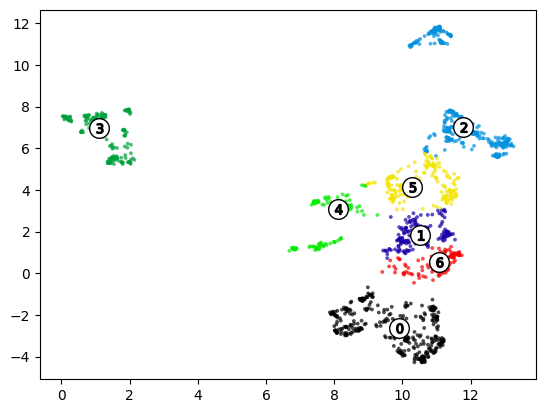

In [ ]:
datos = embedding_2d
colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
plt.scatter(
    datos[:, 0], datos[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
)

# Draw white circles at cluster centers
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="o",
    c="white",
    alpha=1,
    s=200,
    edgecolor="k",
)

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")